# Methods applied

1. Manual feature creation and then Linear regression model applied
2. Statmodels to identify p,q,d parameters and then ARIMA applied

Metric: RMSE.
Goal: RMSE < 48.

# 1. Preparation


In [114]:
# importing necessary libraries

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sklearn
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

In [116]:
print(sklearn.__version__) 

0.22.2.post1


In [117]:
data = pd.read_csv('taxi.csv')

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [119]:
data.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [120]:
# make index as datetime

data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime', drop = True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [121]:
# check wether datetime in ascending order , it is important for time series 

print(data.index.is_monotonic)

True


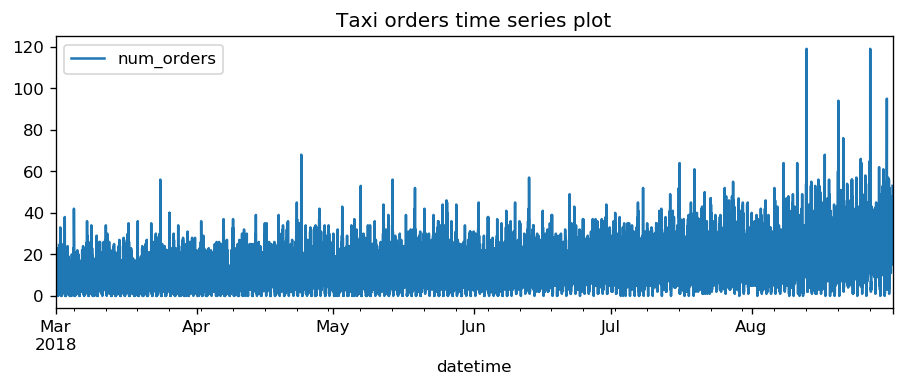

In [122]:
# plot original data

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
data.plot()
plt.title('Taxi orders time series plot')
plt.show()

In [123]:
# check whether we have empty values

data\
    .isna()\
    .sum()\
    .to_frame()\
    .assign(perc = lambda row: 100 * row[0] / data.shape[0])\
    .rename(columns={0: '# of missed values', 'perc': '% of missed values'})

,# of missed values,% of missed values
num_orders,0,0.0


In [124]:
# resample data by 1 hour 

data_hour = data.resample('1H').sum()
data_hour.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


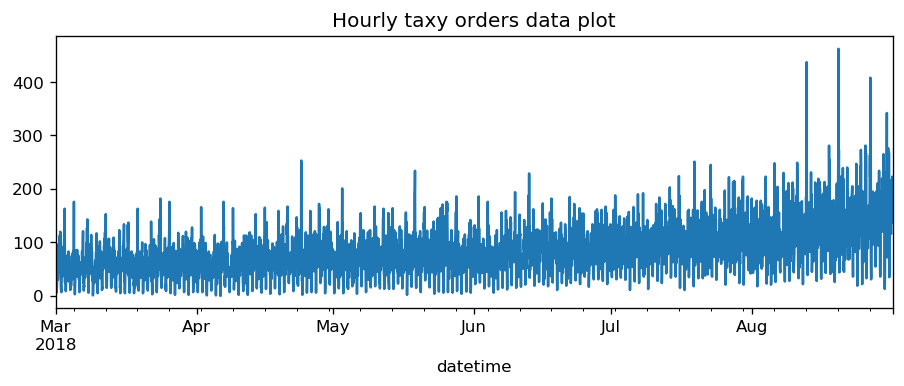

In [125]:
# plotting 1 hour data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
data_hour['num_orders'].plot()
plt.title('Hourly taxy orders data plot')
plt.show()

## 1 Stage summary 

1. Data loaded
2. Datetime transformed into an index
3. Resempling done
4. No missing values
5. Datetime in ascending order (chronological)

# 2. Analysis

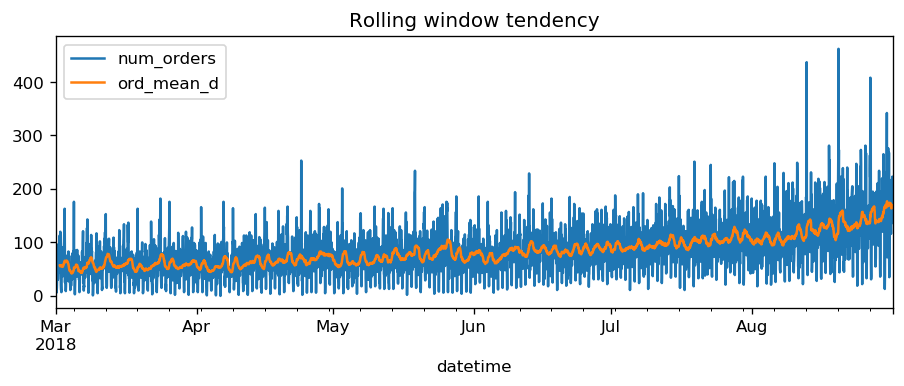

In [126]:
# plot data with rolling window to see tendency 
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
data_hour['ord_mean_d'] = data_hour.rolling(24).mean() 
data_hour[['num_orders','ord_mean_d']].plot()
plt.title('Rolling window tendency')
plt.show()

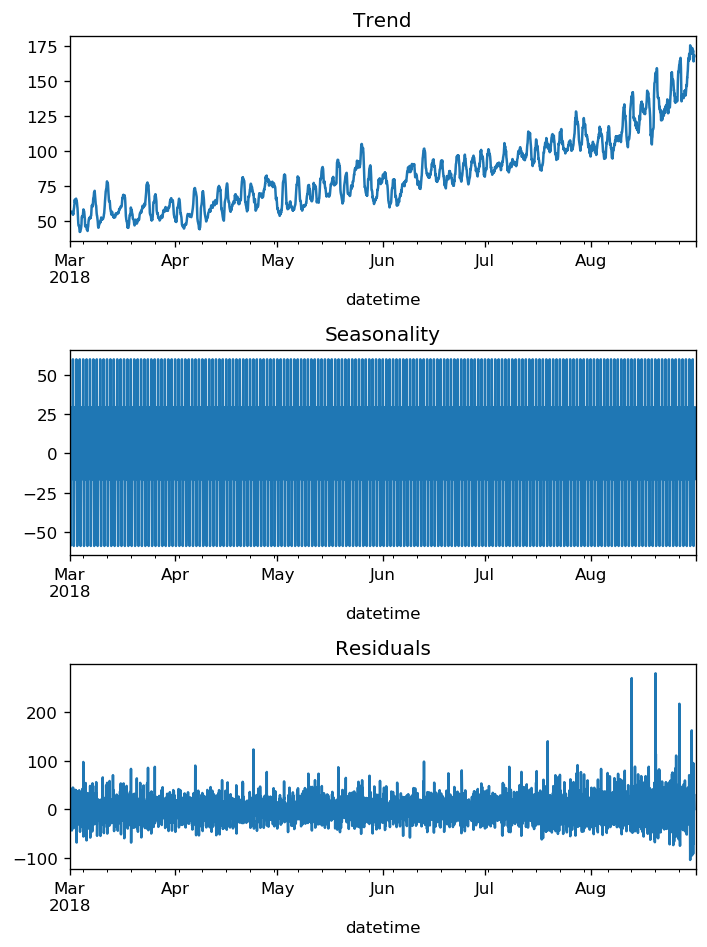

In [127]:
# plot trend, seasons and residuals 
decomposed = seasonal_decompose(data_hour['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Note:
Data is too dense, resample to 1 day

In [128]:
data_day = data.resample('1D').sum()

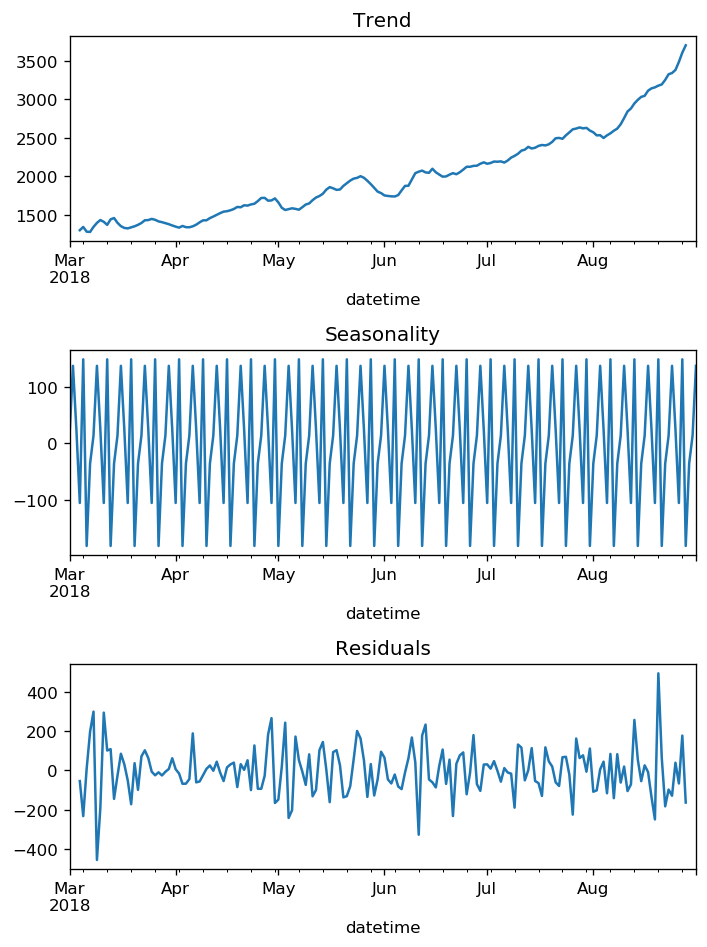

In [129]:
# plot trend, seasonal and residual data for 1 day data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

decomposed = seasonal_decompose(data_day['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [130]:
# there is seasonality, so zomming in to see details
decomposed = seasonal_decompose(data_day)
df = decomposed.seasonal['2018-04-01':'2018-04-19']

In [131]:
# add day name 
df = df.to_frame()
df.reset_index(inplace = True)
df['day_name'] = df['datetime'].dt.day_name()
df.rename(columns={'seasonal':'num_orders'}, inplace=True)

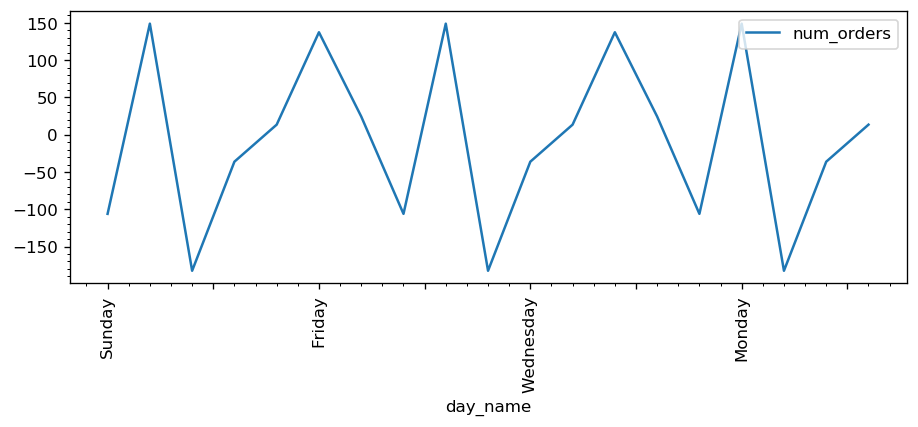

In [132]:
# plot detailed data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df.plot(x='day_name', y ='num_orders')

plt.xticks(x='day_name')
plt.minorticks_on()
plt.xticks(rotation=90)

plt.show()

### Note:

1. The minimun orders on Tuesday
2. The maximum orders on Monday and Friday 


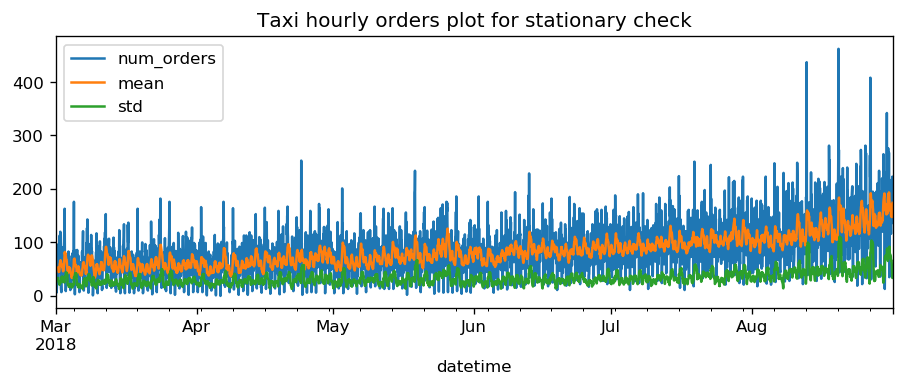

In [133]:
# plot mean and std of hourly orders to see whether data stationary or not

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
data_hour['mean'] = data_hour['num_orders'].rolling(15).mean()
data_hour['std'] = data_hour['num_orders'].rolling(15).std()
data_hour[['num_orders','mean','std']].plot() 
plt.title('Taxi hourly orders plot for stationary check')
plt.show()

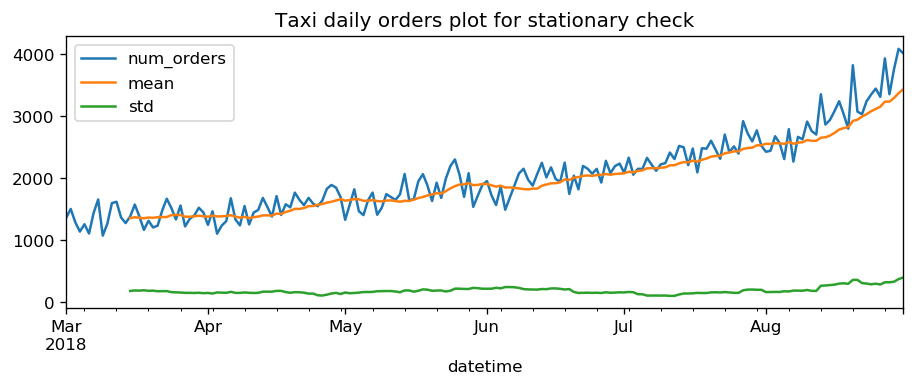

In [134]:
# plot mean and std of daily orders to see whether data stationary or not

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
data_day['mean'] = data_day['num_orders'].rolling(15).mean()
data_day['std'] = data_day['num_orders'].rolling(15).std()
data_day[['num_orders','mean','std']].plot() 
plt.title('Taxi daily orders plot for stationary check')
plt.show()

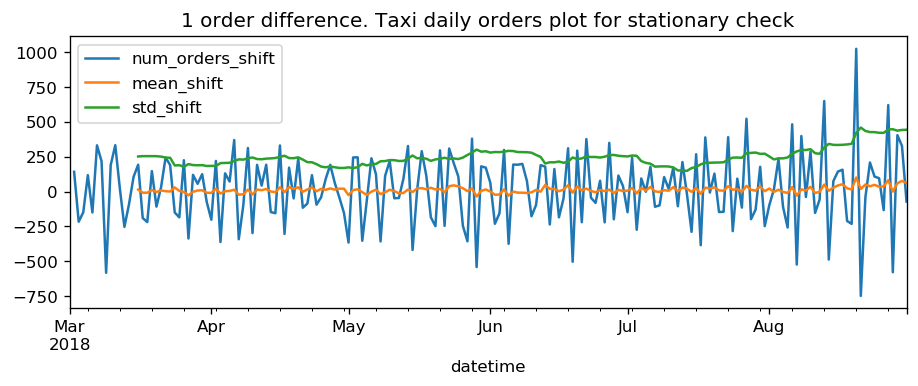

In [135]:
# 1 order difference for daily taxy orders  
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
data_day['num_orders_shift'] = data_day['num_orders'] - data_day['num_orders'].shift()
data_day['mean_shift'] = data_day['num_orders_shift'].rolling(15).mean()
data_day['std_shift'] = data_day['num_orders_shift'].rolling(15).std()
data_day[['num_orders_shift','mean_shift','std_shift']].plot()
plt.title('1 order difference. Taxi daily orders plot for stationary check')
plt.show()

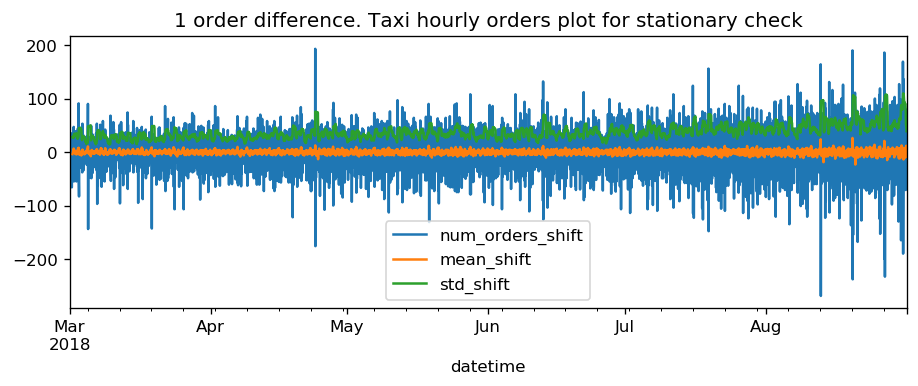

In [136]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
data_hour['num_orders_shift'] = data_hour['num_orders'] - data_hour['num_orders'].shift()
data_hour['mean_shift'] = data_hour['num_orders_shift'].rolling(15).mean()
data_hour['std_shift'] = data_hour['num_orders_shift'].rolling(15).std()
data_hour[['num_orders_shift','mean_shift','std_shift']].plot()
plt.title('1 order difference. Taxi hourly orders plot for stationary check')
plt.show()

### Note 
To check data stationarity we apply  Dickey-Fuller test for unit roots precence. When no unit roots discovered the time series is stationary.  
Use adfuller method from statmodels package. 

In [137]:
# save 1 order difference for hourly taxy orders 
data_day_1_order = data_day['num_orders'].diff(periods=1).dropna()
data_day_1_order

datetime
2018-03-02    142.0
2018-03-03   -216.0
2018-03-04   -149.0
2018-03-05    118.0
2018-03-06   -150.0
              ...  
2018-08-27    621.0
2018-08-28   -579.0
2018-08-29    405.0
2018-08-30    328.0
2018-08-31    -72.0
Freq: D, Name: num_orders, Length: 183, dtype: float64

In [186]:
# apply adfuller() to 1 order daily data

test = sm.tsa.adfuller(data_day_1_order.values)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('a unit root in presence, data is not stationary')
else:
    print('no unit root discovered, data is stationary')

adf:  -3.723181925063725
p-value:  0.0037986467295294283
Critical values:  {'1%': -3.469648263987657, '5%': -2.878798906308495, '10%': -2.5759713094779593}
no unit root discovered, data is stationary


In [139]:
# apply adfuller() to 1 order daily data

test = sm.tsa.adfuller(data_day['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('a unit root in presence, data is not stationary')
else:
    print('no unit root discovered, data is stationary')

adf:  3.728791311564995
p-value:  1.0
Critical values:  {'1%': -3.469413468959902, '5%': -2.8786964197028295, '10%': -2.5759166089965397}
a unit root in presence, data is not stationary


In [140]:
data_hour_1_order = data_hour['num_orders'].diff(periods=1).dropna()
data_hour_1_order

datetime
2018-03-01 01:00:00   -39.0
2018-03-01 02:00:00   -14.0
2018-03-01 03:00:00    -5.0
2018-03-01 04:00:00   -23.0
2018-03-01 05:00:00   -37.0
                       ... 
2018-08-31 19:00:00   -71.0
2018-08-31 20:00:00    18.0
2018-08-31 21:00:00     5.0
2018-08-31 22:00:00    64.0
2018-08-31 23:00:00   -18.0
Freq: H, Name: num_orders, Length: 4415, dtype: float64

In [141]:
test = sm.tsa.adfuller(data_hour['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('a unit root in presence, data is not stationary')
else:
    print('no unit root discovered, data is stationary')

adf:  -3.068924289027955
p-value:  0.02894005140261296
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
no unit root discovered, data is stationary


In [142]:
test = sm.tsa.adfuller(data_hour_1_order.values)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('a unit root in presence, data is not stationary')
else:
    print('no unit root discovered, data is stationary')

adf:  -15.793234257409908
p-value:  1.0958776746526976e-28
Critical values:  {'1%': -3.431842843698785, '5%': -2.8621996550511697, '10%': -2.56712113869159}
no unit root discovered, data is stationary


# 3. Training

In [143]:
# make copy of hourly orders to use for one of the models -> LinearRegression
data_hour_linear = data_hour.copy(deep= True)

In [144]:
data_hour_linear

,num_orders,ord_mean_d,mean,std,num_orders_shift,mean_shift,std_shift
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN,-39.0,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,NaN,-14.0,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,NaN,-5.0,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,NaN,-23.0,NaN,NaN
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,167.541667,147.333333,57.917018,-71.0,-8.800000,71.667087
2018-08-31 20:00:00,154,168.041667,152.400000,54.650578,18.0,5.066667,51.344031
2018-08-31 21:00:00,159,166.416667,160.666667,43.955605,5.0,8.266667,49.600499


In [145]:
data_hour_linear = data_hour_linear.drop(['ord_mean_d','mean','std','mean_shift','num_orders_shift','std_shift'], axis=1)
data_hour_linear

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# Important note "Feature creation":

We DON'T use 
1. Year - we have data less than a year, so we cannot see yearly sesons 
2. Month - similar to Year, we have only data for one may, april and so on. It is not enough
3. Day - the goal is to predict for 2 hours, Day is to big to aggregate 

We USE:
1. Day of the week - we have seen weekly seasonality, which will be good to encoe and pass to our model 
2. Hour - we have seen hourly sesonality 
3. Lagged data - attribute of autoregression, so how yesterday's data impacts today's data
4. Mean in rolling window - trend analogy, we smoothing spikes to have better trend 

In [146]:
# define function to create features for LinearRegression model
# here basiaclly we "decode" parameters for linear regression model

'''
we create features:

- hour
- day of the week
- lagged data  
- mean number of orders calculated in rolling time window 

=================

Parameters of this function:

- data, which is going to be transformed 
- max_lag - number of lag
- rolling_mean_size - number of hours which used to calculate mean value of orders

'''
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    #data['month'] = data.index.
    #data['day'] = data.index.
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

In [147]:
# number of lags = 5
# numver of hours for rolling window calculation = 24, dayly trend 

make_features(data_hour_linear, 5, 24)

In [148]:
data_hour_linear

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,164.875000
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,167.541667
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,168.041667


In [149]:
# split data
train_linear, test_linear = train_test_split(data_hour_linear, shuffle = False, test_size = 0.2)

In [150]:
train_linear = train_linear.dropna()

features_train_linear = train_linear.drop(['num_orders'], axis=1)
features_test_linear = test_linear.drop(['num_orders'], axis=1)
target_train_linear = train_linear['num_orders']
target_test_linear = test_linear['num_orders']

model_linear = LinearRegression()

model_linear.fit(features_train_linear,target_train_linear)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# ARIMA model

In [151]:
data_hour

,num_orders,ord_mean_d,mean,std,num_orders_shift,mean_shift,std_shift
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN,-39.0,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,NaN,-14.0,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,NaN,-5.0,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,NaN,-23.0,NaN,NaN
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,167.541667,147.333333,57.917018,-71.0,-8.800000,71.667087
2018-08-31 20:00:00,154,168.041667,152.400000,54.650578,18.0,5.066667,51.344031
2018-08-31 21:00:00,159,166.416667,160.666667,43.955605,5.0,8.266667,49.600499


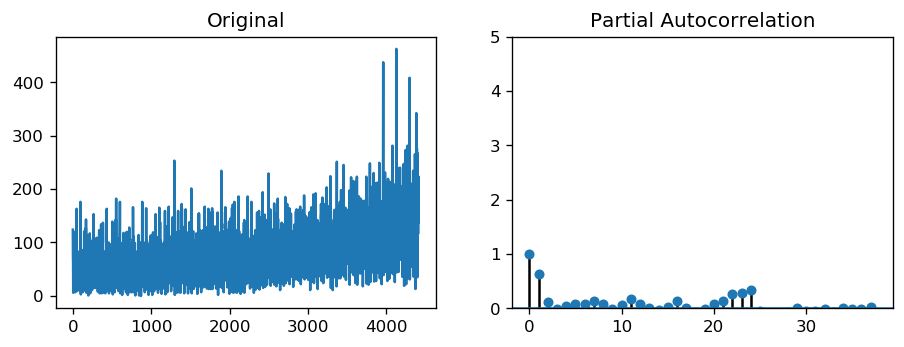

In [152]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(data_hour['num_orders'].values); axes[0].set_title('Original')
axes[1].set(ylim=(0,5))
plot_pacf(data_hour['num_orders'].values, ax=axes[1])

plt.show()

In [153]:
data_hour_1_order.head(3)

datetime
2018-03-01 01:00:00   -39.0
2018-03-01 02:00:00   -14.0
2018-03-01 03:00:00    -5.0
Freq: H, Name: num_orders, dtype: float64

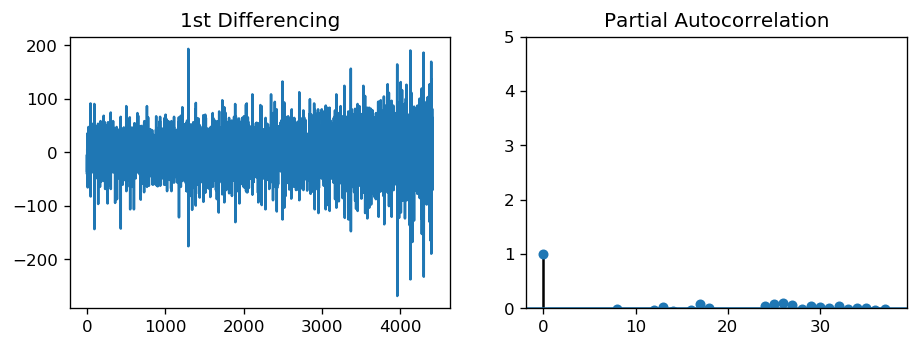

In [154]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(data_hour_1_order.values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data_hour_1_order.values, ax=axes[1])

plt.show()

# AC for q

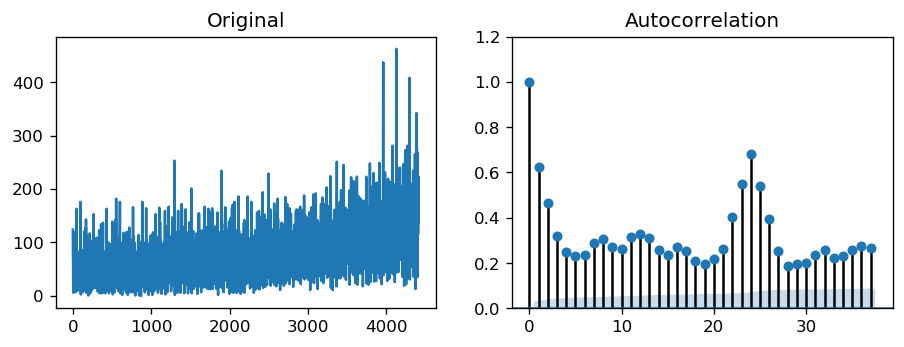

In [155]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(data_hour['num_orders'].values); axes[0].set_title('Original')
axes[1].set(ylim=(0,1.2))
plot_acf(data_hour['num_orders'].values, ax=axes[1])

plt.show()

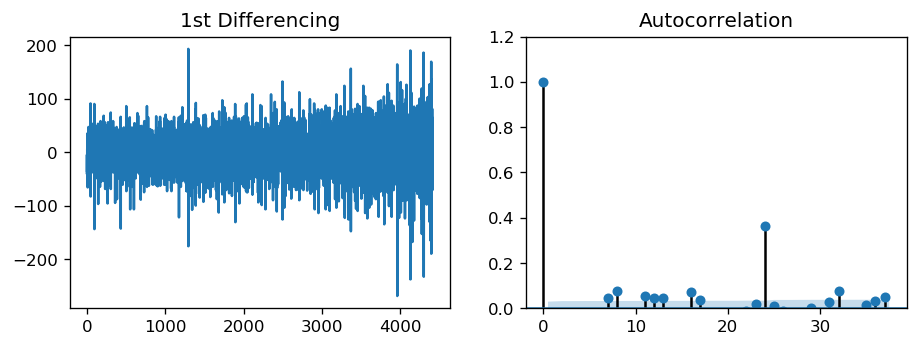

In [156]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(data_hour_1_order.values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data_hour_1_order.values, ax=axes[1])

plt.show()

p -> 1
d -> 1
q -> 2


In [157]:
data_hour_1_order = data_hour_1_order.to_frame()

In [158]:
train_1_order, test_1_order = train_test_split(data_hour_1_order, shuffle = False, test_size = 0.2)

In [159]:
# for d we will use 0, because we use data that has been alredy corrected by 1 order difference
model = ARIMA(train_1_order['num_orders'], order=(1,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             num_orders   No. Observations:                 3532
Model:                     ARMA(1, 2)   Log Likelihood              -16943.799
Method:                       css-mle   S.D. of innovations             29.291
Date:                Wed, 22 Sep 2021   AIC                          33897.598
Time:                        14:02:21   BIC                          33928.446
Sample:                    03-01-2018   HQIC                         33908.603
                         - 07-26-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0141      0.001     15.531      0.000       0.012       0.016
ar.L1.num_orders     0.5126      0.029     17.597      0.000       0.456       0.570
ma.L1.num_orders    -1.0849 

### ARIMA 2. Apply for original data

In [160]:
data_hour_arima = data_hour.drop(['ord_mean_d','mean','std','mean_shift','num_orders_shift','std_shift'], axis=1)
data_hour_arima

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [161]:
train_arima, test_arima = train_test_split(data_hour_arima, shuffle = False, test_size = 0.2)

In [162]:
# for d we will use 1, p -> 2, q->6
model_2 = ARIMA(train_arima['num_orders'], order=(2,1,6))
model_fit_2 = model_2.fit()
print(model_fit_2.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.num_orders   No. Observations:                 3531
Model:                 ARIMA(2, 1, 6)   Log Likelihood              -16871.580
Method:                       css-mle   S.D. of innovations             28.744
Date:                Wed, 22 Sep 2021   AIC                          33763.160
Time:                        14:02:35   BIC                          33824.853
Sample:                    03-01-2018   HQIC                         33785.168
                         - 07-26-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0141      0.002      8.760      0.000       0.011       0.017
ar.L1.D.num_orders     0.7215      0.054     13.417      0.000       0.616       0.827
ar.L2.D.num_orders  

# 4. Test

### Linear regression

In [163]:
predict = model_linear.predict(features_test_linear)

print("RMSE тестовой выборки: ", mean_squared_error(target_test_linear,predict, squared=False))

RMSE тестовой выборки:  45.96425577170464


In [164]:
target_test_linear= target_test_linear.to_frame()

In [165]:
target_test_linear['predict'] = predict

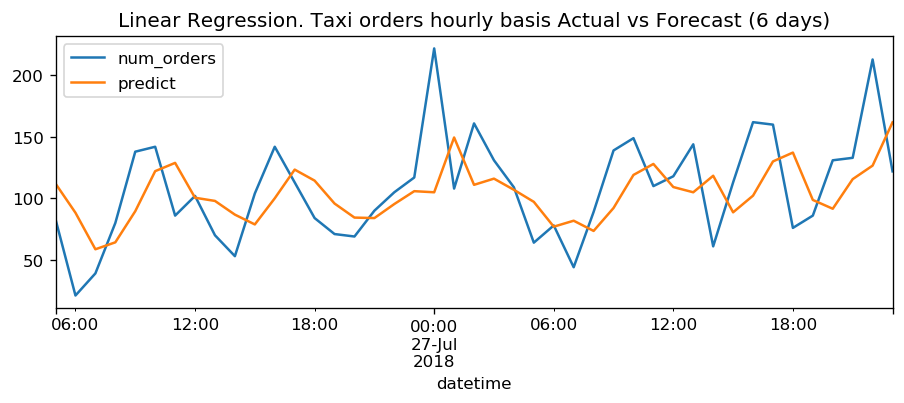

In [166]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
target_test_linear['2018-07-26 05:00:00':'2018-07-27 23:00:00'].plot()
plt.title('Linear Regression. Taxi orders hourly basis Actual vs Forecast (6 days)')
plt.show()

### ARIMA

In [167]:
start_index = test_1_order.index.min()
end_index = test_1_order.index.max()

In [168]:
forecast = model_fit.predict(start=start_index, end=end_index)

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [169]:
print("ARIMA RMSE on test data set: ", mean_squared_error(test_1_order,forecast, squared=False))

ARIMA RMSE on test data set:  53.378465268270006


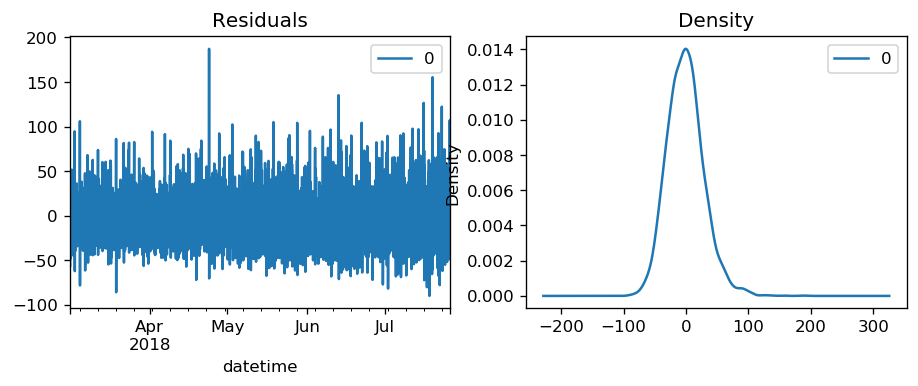

In [170]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


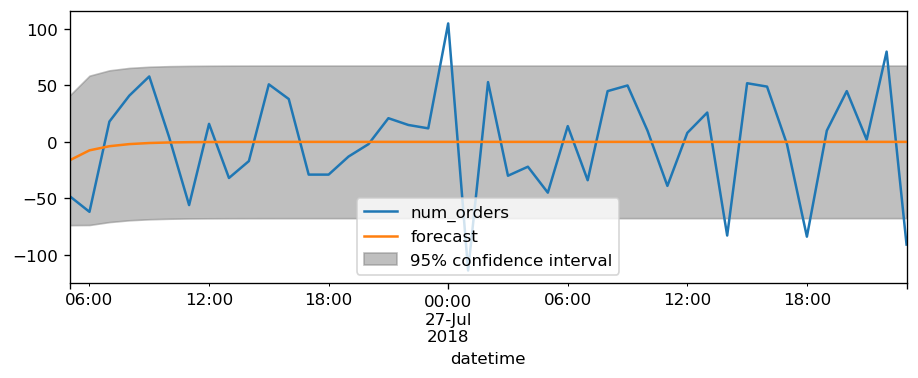

In [171]:
#res = sm.tsa.ARMA(dta, (3, 0)).fit()
fig, ax = plt.subplots()
ax = data_hour_1_order.loc['2018-07-26 05:00:00':'2018-07-27 23:00:00'].plot(ax=ax)
fig = model_fit.plot_predict('2018-07-26 05:00:00', '2018-07-27 23:00:00', dynamic=True, ax=ax, plot_insample=False)
plt.show()

### ARIMA 2 on original data 

In [172]:
start_index_2 = test_arima.index.min()
end_index_2 = test_arima.index.max()

In [173]:
forecast_2 = model_fit_2.predict(start=start_index_2, end=end_index_2)

In [174]:
print("ARIMA RMSE on test data set: ", mean_squared_error(test_arima,forecast_2, squared=False))

ARIMA RMSE on test data set:  136.29103562532276


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


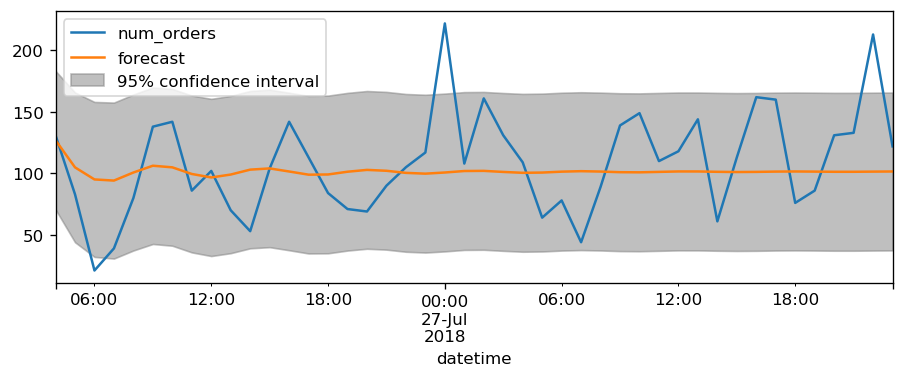

In [175]:
fig, ax = plt.subplots()
ax = data_hour_arima.loc['2018-07-26 04:00:00':'2018-07-27 23:00:00'].plot(ax=ax)
fig = model_fit_2.plot_predict('2018-07-26 04:00:00', '2018-07-27 23:00:00', dynamic=True, ax=ax, plot_insample=False)
plt.show()

## Итого
 
 1. LinearRegression got metric results RMSE = 46
 2. ARIMA with 1st order difference got RMSE = 53
 3. ARIMA with hourly resampling without order difference but with d = 1 (stat model will apply order difference internally), got RMSE = 136
 
 Graphical representation:
 
1. LinearRegression close to initial time series 
2. ARIMA, shows some spikes at the beginning of forecast but than begin to draw a straight line, probably because of the short horizon of prediction (hours) 

### Notes 
ARIMA 
1. d - order difference , making time series stationary 
2. p - lagged data
3. q - mean rolling window, in our case if we use q = 1 we consider error for the last our prediction, we train of previous errors. 

To improve ARIMA results gridsearch of p,q,d is good way to start. 

### Experimental cells 

In [176]:
#delete data from dataframe
#data_day_1_order.drop(data_day_1_order.index, inplace=True)

In [184]:
predict_2 = model_linear.predict(features_train_linear)
print("RMSE on train data:", mean_squared_error(target_train_linear,predict_2, squared=False))

RMSE on train data: 29.177919352482444


In [178]:
data_hour

,num_orders,ord_mean_d,mean,std,num_orders_shift,mean_shift,std_shift
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN,-39.0,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,NaN,-14.0,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,NaN,-5.0,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,NaN,-23.0,NaN,NaN
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,167.541667,147.333333,57.917018,-71.0,-8.800000,71.667087
2018-08-31 20:00:00,154,168.041667,152.400000,54.650578,18.0,5.066667,51.344031
2018-08-31 21:00:00,159,166.416667,160.666667,43.955605,5.0,8.266667,49.600499


In [179]:
train_hour, test_hour = train_test_split(data_hour, shuffle = False, test_size = 0.1)

In [180]:
model = ARIMA(train_hour.num_orders, order=(1,1,2))
model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.num_orders   No. Observations:                 3973
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -19254.128
Method:                       css-mle   S.D. of innovations             30.776
Date:                Wed, 22 Sep 2021   AIC                          38518.257
Time:                        14:02:41   BIC                          38549.693
Sample:                    03-01-2018   HQIC                         38529.404
                         - 08-13-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0153      0.002      7.492      0.000       0.011       0.019
ar.L1.D.num_orders     0.4923      0.027     18.462      0.000       0.440       0.545
ma.L1.D.num_orders  

In [181]:
start_index = test_hour.index.min()
end_index = test_hour.index.max()

In [182]:
forecast = model_fit.predict(start=start_index, end=end_index)

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [185]:
print("ARIMA RMSE on test data: ", mean_squared_error(test_hour,forecast, squared=False))

ValueError: y_true and y_pred have different number of output (7!=1)